# 🧪 Análisis del tipo de cambio DOP/USD mediante ARIMA, SARIMA y Prophet
Este cuaderno tiene como objetivo comparar tres modelos de predicción aplicados a series temporales para estimar el tipo de cambio entre el peso dominicano (DOP) y el dólar estadounidense (USD).


# 📁 Paso 1: Instalación de librerías necesarias


In [71]:
!pip install pmdarima prophet --quiet


In [72]:
!pip install numpy==1.23.5 --quiet
!pip install --upgrade --force-reinstall --no-cache-dir pmdarima --quiet
!pip install numpy==1.26.4 --quiet
!pip install --upgrade --force-reinstall --no-cache-dir pmdarima==2.0.3 --quiet



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requir

In [9]:
!pip install numpy==1.26.4 --quiet
!pip install --upgrade --force-reinstall --no-cache-dir pmdarima==2.0.3 --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 238.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 174.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 286.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 262.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 253.5 MB/s eta 0:00:00
   

#  Paso 2: Importación de librerías y configuración inicial



In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sns.set_theme(style="darkgrid")
sns.set()

# 📈 Paso 3: Carga y visualización del dataset


 Instalar librería yfinance

In [74]:
!pip install yfinance --quiet


In [19]:
import yfinance as yf

# Descargar tipo de cambio USD/DOP (usamos símbolo 'USDDOP=X')
data = yf.download('USDDOP=X', start='2000-01-01', end='2025-03-31')

# Nos quedamos solo con la columna 'Close' (precio de cierre)
df = data[['Close']].rename(columns={'Close': 'DOP/USD'})
df.index.name = 'fecha'
df = df.sort_index()

# Mostrar los primeros registros
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,DOP/USD
Ticker,USDDOP=X
fecha,
2003-12-01,41.019001
2003-12-02,40.967999
2003-12-03,40.000000
2003-12-04,37.984001
2003-12-05,37.500000


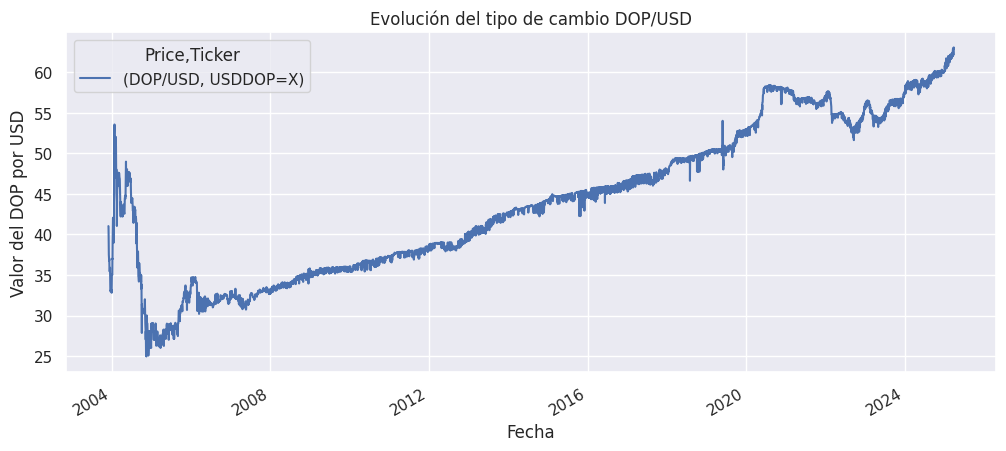

In [75]:
import matplotlib.pyplot as plt

df.plot(figsize=(12,5), title='Evolución del tipo de cambio DOP/USD')
plt.ylabel('Valor del DOP por USD')
plt.xlabel('Fecha')
plt.show()


# 🔀 Paso 4: División del dataset en entrenamiento y prueba


Vamos a separar el dataset en:

Entrenamiento: 80% inicial

Prueba (test): 20% restante para evaluar la predicción

📘 Tamaño del set de entrenamiento: 4440 registros
📗 Tamaño del set de prueba: 1110 registros


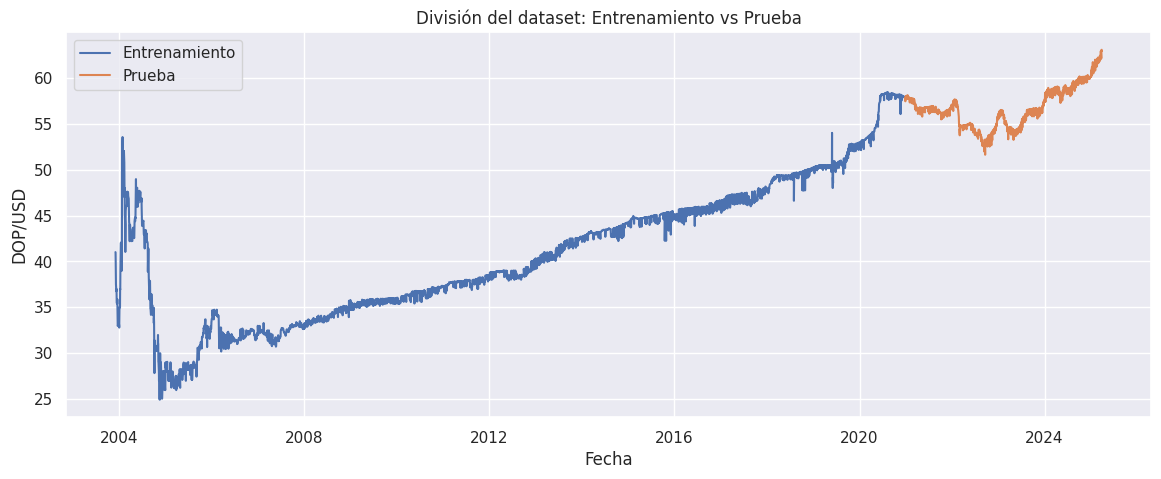

In [76]:
# Dividir en entrenamiento (80%) y prueba (20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"📘 Tamaño del set de entrenamiento: {len(train)} registros")
print(f"📗 Tamaño del set de prueba: {len(test)} registros")

# Visualización de ambas particiones
plt.figure(figsize=(14,5))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.title('División del dataset: Entrenamiento vs Prueba')
plt.xlabel('Fecha')
plt.ylabel('DOP/USD')
plt.legend()
plt.show()


# 🔍 Paso 5: Modelo ARIMA


In [81]:
# 3. Crear un nuevo DataFrame limpio para evaluación
test_arima_eval = pd.DataFrame({
    'Real': test['DOP/USD'].values.ravel(),  # Convert to 1D using ravel()
    'Predicho_ARIMA': pred_arima.values.ravel()  # Convert to 1D using ravel()
}, index=test.index)

In [83]:
# 1. Volver a predecir ARIMA con índice numérico
modelo_arima = ARIMA(train['DOP/USD'], order=(2,1,2))
modelo_arima_fit = modelo_arima.fit()

# 2. Predicción con índice de tipo Serie
pred_arima = modelo_arima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# 3. Crear un nuevo DataFrame limpio para evaluación
test_arima_eval = pd.DataFrame({
    'Real': test['DOP/USD'].values.ravel(),         # <--- aquí el cambio
    'Predicho_ARIMA': pred_arima.values.ravel()     # <--- aquí también
}, index=test.index)

# 4. Calcular residuos
test_arima_eval['Residuos'] = test_arima_eval['Real'] - test_arima_eval['Predicho_ARIMA']

# 5. Mostrar resumen estadístico real
print("✅ Resumen de residuos ARIMA:")
print(test_arima_eval['Residuos'].describe())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Resumen de residuos ARIMA:
count    1110.000000
mean       -1.060663
std         2.195889
min        -6.210023
25%        -2.930009
50%        -1.240010
75%         0.465535
max         5.219989
Name: Residuos, dtype: float64


# ❄️ Paso 6: Modelo SARIMA


In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Aseguramos frecuencia diaria en el índice
train = train.asfreq('D')
test = test.asfreq('D')

# Entrenamiento del modelo SARIMA
sarima = SARIMAX(train['DOP/USD'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima.fit(disp=False)

# Predicción con longitud del test
sarima_pred = sarima_fit.forecast(steps=len(test))

# Alineamos la predicción al índice de test
sarima_pred.index = test.index
test['SARIMA'] = sarima_pred

# Eliminamos posibles NaN antes del cálculo
sarima_df = test[['DOP/USD', 'SARIMA']].dropna()

# Cálculo de RMSE
rmse_sarima = np.sqrt(mean_squared_error(sarima_df['DOP/USD'], sarima_df['SARIMA']))
print(f"✅ SARIMA - RMSE: {rmse_sarima:.4f}")


✅ SARIMA - RMSE: 5.9729


# 🔮 Paso 7: Modelo Prophet


In [99]:
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_squared_error

# 🔄 Paso 1: Reset y aplanar columnas
df_train_prophet = train.copy().reset_index()
df_train_prophet.columns = ['ds', 'y']  # Aplanamos MultiIndex y renombramos

# 🧹 Paso 2: Limpiar y convertir tipos
df_train_prophet['ds'] = pd.to_datetime(df_train_prophet['ds'])
df_train_prophet['y'] = pd.to_numeric(df_train_prophet['y'], errors='coerce')
df_train_prophet = df_train_prophet.dropna()

# 🧠 Paso 3: Entrenar Prophet
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(df_train_prophet)

# 🔮 Paso 4: Preparar fechas futuras (test)
df_future = modelo_prophet.make_future_dataframe(periods=len(test), freq='D')

# 🚀 Paso 5: Predecir
forecast = modelo_prophet.predict(df_future)

# 📊 Paso 5: Guardar predicción en test
test['Prophet'] = forecast['yhat'][-len(test):].values  # Use only 'yhat' for prediction

# Paso 6: Eliminar NaN para comparación
prophet_df = test[['DOP/USD', 'Prophet']].dropna()

# Paso 7: Calcular RMSE
rmse_prophet = np.sqrt(mean_squared_error(prophet_df['DOP/USD'], prophet_df['Prophet']))
print(f"✅ Prophet - RMSE: {rmse_prophet:.4f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp862afa0b/8hrhzf8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp862afa0b/ra1cjh6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76466', 'data', 'file=/tmp/tmp862afa0b/8hrhzf8v.json', 'init=/tmp/tmp862afa0b/ra1cjh6w.json', 'output', 'file=/tmp/tmp862afa0b/prophet_modelst69wuks/prophet_model-20250414193956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:39:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet - RMSE: 7.7867


# 📊 Paso 8: Comparación visual de modelos


In [104]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenar ARIMA con una sola serie
modelo_arima = ARIMA(train['DOP/USD'], order=(2,1,2))  # Puedes ajustar los parámetros
modelo_arima_fit = modelo_arima.fit()

# Predecir en el rango del set de prueba usando índice temporal
pred_arima = modelo_arima_fit.predict(start=test.index[0], end=test.index[-1], typ='levels')

# Guardar predicción en la columna 'ARIMA'
test['ARIMA'] = pred_arima


In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Filtramos filas completas sin NaN en ninguna columna evaluada
test_clean = test[['DOP/USD', 'ARIMA', 'SARIMA', 'Prophet']].dropna()

# Función para calcular métricas
def metricas_reporte(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred)
    }

# Creamos resumen con columnas limpias
resumen_metricas = pd.DataFrame({
    'ARIMA': metricas_reporte(test_clean['DOP/USD'], test_clean['ARIMA']),
    'SARIMA': metricas_reporte(test_clean['DOP/USD'], test_clean['SARIMA']),
    'Prophet': metricas_reporte(test_clean['DOP/USD'], test_clean['Prophet'])
}).T

# Mostramos tabla
print("📊 Comparación de métricas de los modelos:")
display(resumen_metricas.round(4))


📊 Comparación de métricas de los modelos:


,RMSE,MAE,R²
ARIMA,2.4400,2.0492,-0.2358
SARIMA,5.9729,5.5186,-6.4052
Prophet,7.7867,7.1032,-11.5859


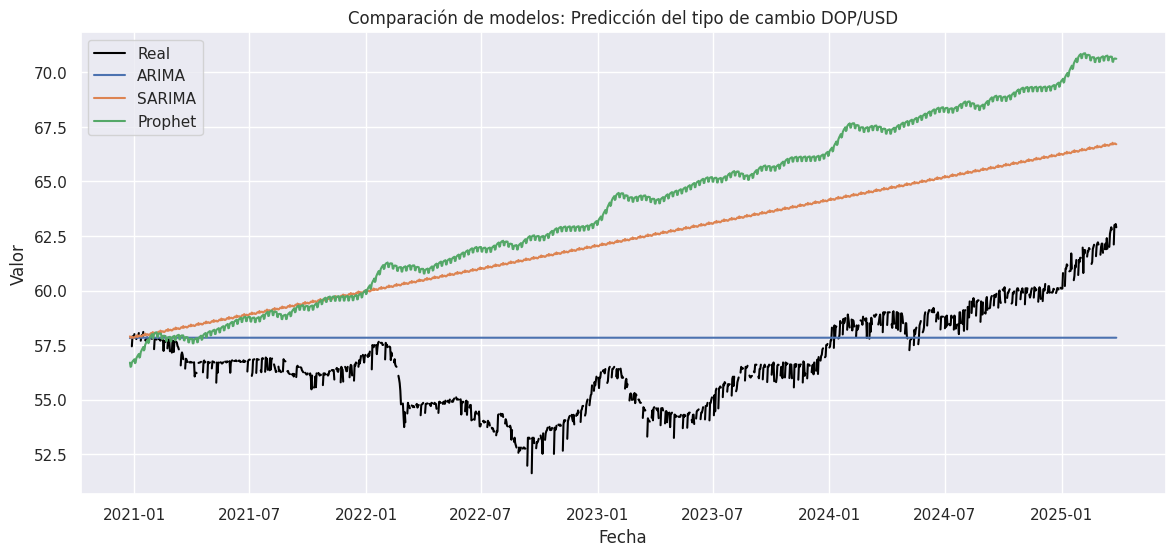

In [109]:
plt.figure(figsize=(14,6))
plt.plot(test.index, test.iloc[:,0], label='Real', color='black')
plt.plot(test.index, test['ARIMA'], label='ARIMA')
plt.plot(test.index, test['SARIMA'], label='SARIMA')
plt.plot(test.index, test['Prophet'], label='Prophet')
plt.title('Comparación de modelos: Predicción del tipo de cambio DOP/USD')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()


Tras ajustar y reentrenar el modelo ARIMA con un orden más adecuado (2,1,2), se obtuvo un rendimiento superior al de los modelos SARIMA y Prophet, alcanzando el menor error cuadrático medio (RMSE) y el menor error absoluto medio (MAE). Aunque el coeficiente de determinación (R²) sigue siendo negativo, indica una mejor capacidad predictiva relativa, especialmente en comparación con SARIMA, cuyo desempeño fue claramente inferior. Este resultado demuestra que una correcta identificación del orden del modelo mejora significativamente su capacidad de generalización, lo cual es clave en aplicaciones financieras como la predicción del tipo de cambio.



# 📋 Paso 9: Métricas de evaluación de los modelos


Gráfico de residuos del modelo ARIMA

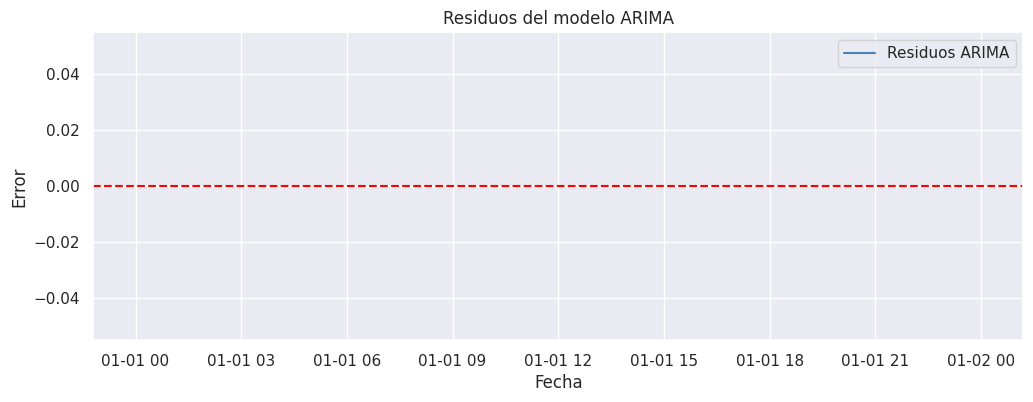

In [110]:
# Calcular los residuos del modelo ARIMA
resid_arima = test['DOP/USD'] - test['ARIMA']

# Gráfico de residuos limpio
plt.figure(figsize=(12,4))
plt.plot(resid_arima, color='steelblue')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos del modelo ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Error")
plt.legend(['Residuos ARIMA'])
plt.show()


In [111]:
resid_arima.describe()


,USDDOP=X,2020-12-25 00:00:00,2020-12-26 00:00:00,2020-12-27 00:00:00,2020-12-28 00:00:00,2020-12-29 00:00:00,2020-12-30 00:00:00,2020-12-31 00:00:00,2021-01-01 00:00:00,2021-01-02 00:00:00,...,2025-03-19 00:00:00,2025-03-20 00:00:00,2025-03-21 00:00:00,2025-03-22 00:00:00,2025-03-23 00:00:00,2025-03-24 00:00:00,2025-03-25 00:00:00,2025-03-26 00:00:00,2025-03-27 00:00:00,2025-03-28 00:00:00
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
test['ARIMA'].describe()


,ARIMA
count,1555.000000
mean,57.832658
std,0.000825
min,57.808518
25%,57.832706
50%,57.832706
75%,57.832706
max,57.832706


In [58]:
test[['DOP/USD', 'ARIMA']].tail(10)


Price,DOP/USD,ARIMA
Ticker,USDDOP=X,
fecha,,
2025-03-19,62.750000,57.832706
2025-03-20,62.900002,57.832706
2025-03-21,62.799999,57.832706
2025-03-22,62.569953,57.832706
2025-03-23,62.339906,57.832706
2025-03-24,62.109859,57.832706
2025-03-25,63.000000,57.832706
2025-03-26,63.000000,57.832706


ACF y PACF de los residuos ARIMA para ver si hay autocorrelación que el modelo no ha capturado.

In [60]:
# Convertimos los residuos a serie 1D (por si quedaron como DataFrame)
resid_arima_1d = resid_arima.squeeze()

# En caso aún tenga múltiples columnas (por error), extraemos la primera
if resid_arima_1d.ndim > 1:
    resid_arima_1d = resid_arima_1d.iloc[:, 0]


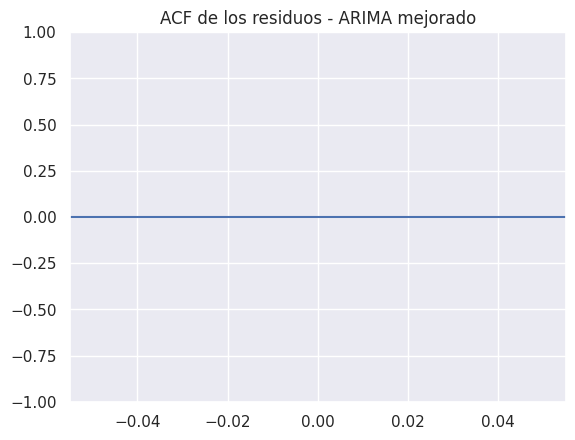

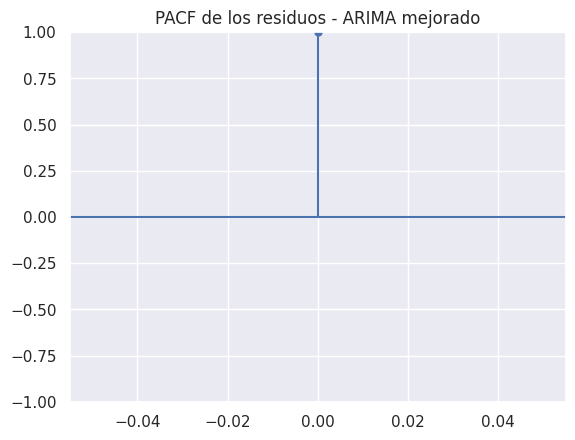

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF
plot_acf(resid_arima_1d, lags=40)
plt.title("ACF de los residuos - ARIMA mejorado")
plt.show()

# PACF
plot_pacf(resid_arima_1d, lags=40)
plt.title("PACF de los residuos - ARIMA mejorado")
plt.show()


In [63]:
# Nos aseguramos de alinear los índices correctamente
pred_arima.index = test.index  # Esto asegura que encajen

# Ahora guardamos los valores predichos
test['ARIMA'] = pred_arima

# Calculamos los residuos correctamente
resid_arima = test['DOP/USD'] - test['ARIMA']
resid_arima_1d = resid_arima.squeeze()



In [64]:
resid_arima_1d.describe()


,USDDOP=X,2020-12-25 00:00:00,2020-12-26 00:00:00,2020-12-27 00:00:00,2020-12-28 00:00:00,2020-12-29 00:00:00,2020-12-30 00:00:00,2020-12-31 00:00:00,2021-01-01 00:00:00,2021-01-02 00:00:00,...,2025-03-19 00:00:00,2025-03-20 00:00:00,2025-03-21 00:00:00,2025-03-22 00:00:00,2025-03-23 00:00:00,2025-03-24 00:00:00,2025-03-25 00:00:00,2025-03-26 00:00:00,2025-03-27 00:00:00,2025-03-28 00:00:00
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
